In [1]:
%matplotlib inline
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st

**Note**: on this notebook I am just practicing concepts of multiple linear regression. I am not considering some aspects related to machine learning like the imputation of missing values or the normalisation of the predictor variables. 

## Loading and processing the data

The dataset used in this notebook is the Auto MPG dataset from the UCI Machine Learning Repository: (https://archive.ics.uci.edu/ml/datasets/Auto+MPG).

The mpg column corresponds to the response variable. All the predictor variables can be interpreted as numerical variables except origin, that is categorical.

In [2]:
df = pd.read_csv('data/auto-mpg.csv', sep='\s+', header=None, usecols=range(8))
df.columns = ['mpg', 'cylinders', 'displacement',
              'horsepower', 'weight', 'acceleration',
              'model_year', 'origin']
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


Removing rows with missing values:

In [3]:
df = df[~(df.horsepower == '?')]
df.horsepower = df.horsepower.astype(float)

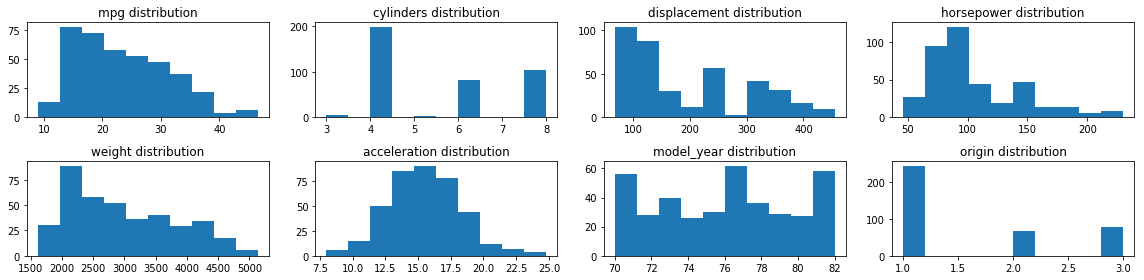

In [4]:
fig, ax = plt.subplots(2,4)

ax[0,0].hist(df.mpg)
ax[0,0].set_title('mpg distribution')

ax[0,1].hist(df.cylinders)
ax[0,1].set_title('cylinders distribution')

ax[0,2].hist(df.displacement)
ax[0,2].set_title('displacement distribution')

ax[0,3].hist(df.horsepower)
ax[0,3].set_title('horsepower distribution')

ax[1,0].hist(df.weight)
ax[1,0].set_title('weight distribution')

ax[1,1].hist(df.acceleration)
ax[1,1].set_title('acceleration distribution')

ax[1,2].hist(df.model_year)
ax[1,2].set_title('model_year distribution')

ax[1,3].hist(df.origin)
ax[1,3].set_title('origin distribution')

fig.set_figwidth(16)
fig.set_figheight(4)
plt.tight_layout()

We are testing now whether any pair of predictors are collinear, that is, whether any pair of predictors is correlated. Collinearity is an issue since small variations in the data or the model may produce large erratic changes in the point estimates of the multiple regression model. This does not affect the accuracy of the prediction as a whole, but may have an impact on the accuracy of the prediction of each individual predictor.

There are 7 predictor variables, making a total of 7*6/2 = 21 combinations.

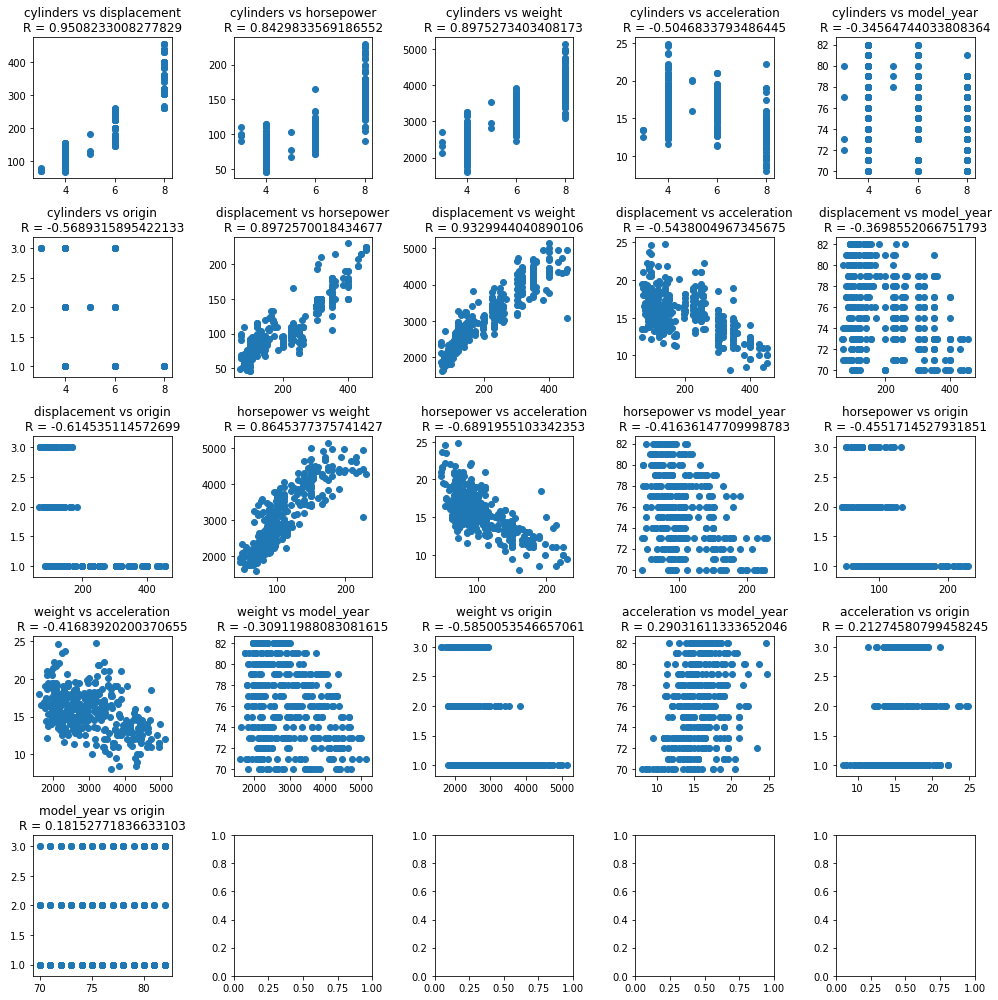

In [5]:
fig, ax = plt.subplots(5,5)
row = 0
col = 0

for i in range(1,len(df.columns)):
    for j in range(i+1,len(df.columns)):
        
        var1 = df[df.columns[i]]
        var2 = df[df.columns[j]]
        
        ax[row, col].scatter(var1, var2)
        
        R = 1/(len(df)-1)*np.sum(((var1-var1.mean())/var1.std())*((var2-var2.mean())/var2.std()))
        
        ax[row, col].set_title(df.columns[i] + ' vs ' + df.columns[j] + '\nR = ' + str(R))
        
        col = col + 1
        if col > 4:
            col = 0
            row = row + 1
            
fig.set_figwidth(14)
fig.set_figheight(14)
plt.tight_layout()

There seems to be a somehow strong linear relationship between a set of four variables: displacement, horsepower, weight and cylinders. We will examine later, during model selection, how this may affect the accuracy of the model.



In order to use categorical predictor variables in our multiple regression model (in our case only the 'origin' predictor is categorical) we need to transform them into indicator or dummy variables. An indicator variable takes the value 1 or 0 depending on whether the value represented by the indicator variable was the value of the original categorical variable in the original dataset. If the categorical variable only has two levels only one indicator variable is required. 

In [6]:
print(np.unique(df.origin))

[1 2 3]


In [7]:
for v in [1,2]:
    df['origin_' + str(v)] = (df.origin == v).astype(int)
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,origin_1,origin_2
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,1,0
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,1,0
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,1,0
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,1,0
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,1,0


## Fitting the multiple regression model

We will use least squares to fit the multiple regression model.

In [8]:
columns = ['cylinders', 'displacement', 'horsepower', 'weight',
        'acceleration', 'model_year', 'origin_1', 'origin_2']

Y = df.mpg.values
X = df[columns].values

X = np.append(np.ones((X.shape[0], 1)), X, axis=1)

B = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), Y)

print('Fitted linear model:')
print('intercept: ' + str(B[0]))
for i in range(len(columns)):
    print(columns[i] + ': ' + str(B[i+1]))
    
residuals = Y - np.dot(X, B)

adj_r2 = 1 - ((Y.shape[0]-1)*(np.std(residuals)**2)/((Y.shape[0]-len(columns)-1)*(np.std(Y)**2)))
print('\nAdjusted R2: ' + str(adj_r2))

Fitted linear model:
intercept: -15.101373838815864
cylinders: -0.4897094240462845
displacement: 0.023978644027860388
horsepower: -0.018183464038842398
weight: -0.006710384127377211
acceleration: 0.07910303601135334
model_year: 0.7770269391010405
origin_1: -2.8532282284775388
origin_2: -0.22322586846010029

Adjusted R2: 0.8205273961763958


Let's use an added variable plots to visualise the relationship between the response variable and each predictor variable, individually. The added variable plot for x_0 is built by plotting the residuals of the response variable after fitting the model with all the predictor variables except x_0 vs. the residuals of x_0 after fitting a regression for x_0 with all the other predictor variables. 

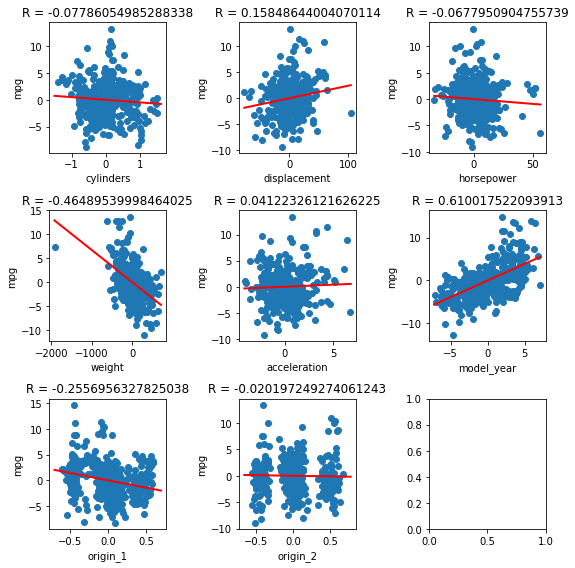

In [9]:
def added_variable_plot(df, predictor, ax):
    Y = df.mpg.values
    X_0 = df[predictor].values
    
    X = df[columns]
    del X[predictor]
    X = X.values
    
    X = np.append(np.ones((X.shape[0], 1)), X, axis=1)
    
    B_y = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), Y)
    B_x0 = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), X_0)
    
    residuals_y = Y - np.dot(X, B_y)
    residuals_x0 = X_0 - np.dot(X, B_x0)
    
    ax.scatter(residuals_x0, residuals_y)
    ax.set_xlabel(predictor)
    ax.set_ylabel('mpg')
    
    # Least squares of the residuals(
    R = 1/(Y.shape[0] - 1)*np.sum((residuals_x0 - np.mean(residuals_x0))/np.std(residuals_x0)*(residuals_y - np.mean(residuals_y))/np.std(residuals_y))
    b1 = R*np.std(residuals_y)/np.std(residuals_x0)
    b0 = np.mean(residuals_y) - b1*np.mean(residuals_x0)
    xo = np.min(residuals_x0) - 0.1
    xf = np.max(residuals_x0) + 0.1
    ax.plot([xo, xf], [b1*xo + b0, b1*xf + b0], 'r', lw=2)
    ax.set_title('R = ' + str(R))
    
fig, ax = plt.subplots(3,3)
row = 0
column = 0
for c in columns:
    added_variable_plot(df, c, ax[row][column])
    column = column + 1
    if column > 2:
        column = 0
        row = row + 1

fig.set_figwidth(8)
fig.set_figheight(8)
plt.tight_layout()

## Checking model assumptions

Is a linear multiple regression model appropriate with this data? The conditions we need to evaluate are:

- The residuals are normally distributed
- The variability of the residuals is nearly normal
- The residuals are independent
- Each variable is linearly related to the outcome

We will assess these conditions by means of a series of plots. We first build a q-q plot to test whether the residuals are normally distributed:

Text(0,0.5,'theoretical')

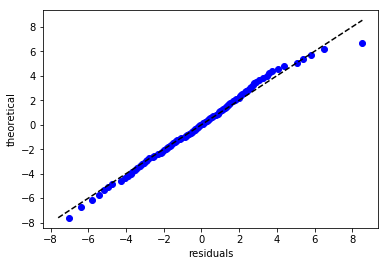

In [10]:
quantiles = np.arange(0.01,0.99,0.01)
q_theoretical = [st.norm.ppf(i, loc=np.mean(residuals), scale=np.std(residuals)) for i in quantiles]

q_sample = [np.percentile(residuals, i*100) for i in quantiles]

fig, ax = plt.subplots()
ax.scatter(q_sample, q_theoretical, color='blue')

min_value = min(np.min(q_theoretical), np.min(q_sample))
max_value = max(np.max(q_theoretical), np.max(q_sample))
ax.plot([min_value, max_value], [min_value, max_value], 'k--')

ax.set_xlabel('residuals')
ax.set_ylabel('theoretical')

Residuals seem to be normally distributed with maybe some outliers on the right side of the distribution.

Let's test now whether the variability of the residuals is nearly constant, by means of a plot of the residuals against the fitted values:

Text(0,0.5,'residuals')

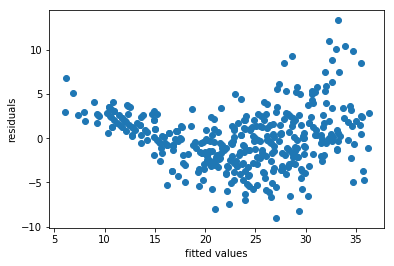

In [11]:
fig, ax = plt.subplots()
ax.scatter(np.dot(X, B), residuals)
ax.set_xlabel('fitted values')
ax.set_ylabel('residuals')

There seems to be non-linearity in the data. A linear multiple regression model may not be the best model for this data. 

To test the independence of the residuals we plot the residuals in the order in which the observations were observed. We are assumed that the data in the original dataset was stored in the order in which the observations were made:

Text(0,0.5,'residuals')

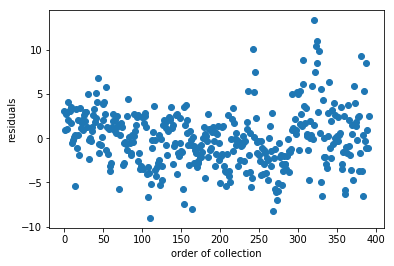

In [12]:
fig, ax = plt.subplots()
ax.plot(residuals, 'o')
ax.set_xlabel('order of collection')
ax.set_ylabel('residuals')

There seems to be a non-linear pattern in this plot as well. The variability seems to be higher for some subsets of observations that are very close to each other in time. 

Finally, we test the residuals against each predictor variable, in order to determine whether there is any different variability between groups in the case of the categorical variable and whether the variability is constant in the case of the numerical variables:

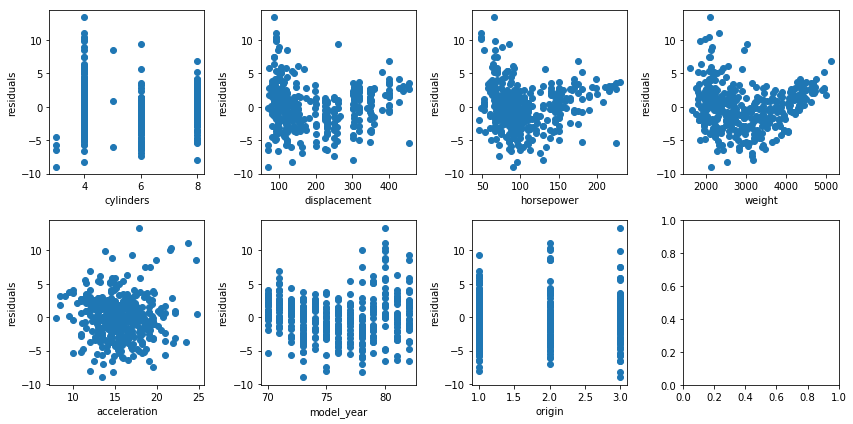

In [13]:
original_columns = ['cylinders', 'displacement', 'horsepower', 'weight',
        'acceleration', 'model_year', 'origin']

fig, ax = plt.subplots(2,4)
row = 0
col = 0
for c in original_columns:
    ax[row, col].plot(df[c], residuals, 'o')
    ax[row, col].set_xlabel(c)
    ax[row, col].set_ylabel('residuals')
    
    col = col + 1
    if col > 3:
        col = 0
        row = row + 1
fig.set_figwidth(12)
fig.set_figheight(6)
plt.tight_layout()

This plots are also showing the non-linear relationship between some variables and the residuals, as well as different variability between groups in the case of the cylinders variable. 

The aim of these plots is to determine whether some structure still exists in the data after fitting the multiple regression model. We may need to adjust the model to try to account for the extra structure (for instance, the non-constant variability of the residuals). If we are not able to do so, we can still report the results, that is, the fitted linear model as long as we also report it shortcomings. 

In the case of the specific dataset in this notebook, it seems that a linear model may not be the best type of model to predict mpg from the rest of the variables. There's a clear non-linear trend in the data, and other assumptions required to apply a multiple regression linear model do not hold as well.

However, and for the purpose of finish demonstrating some aspects of multiple linear regression (model selection) we will keep using this dataset as an example in the next section. 

## Model selection

The full model, that is, the model which includes the complete set of predictor variables, may not be the best model in terms of prediction accuracy. Model selection is a collection of techniques which aim is the selection of a subset of predictor variables in order to increase the prediction accuracy of the model.

In this section we will demonstrate how to use stepwise model selection. In stepwise model selection we proceed by adding (forward selection) or removing (backward elimination) one predictor variable at a time. To evaluate the model produced at each step we can either use adjusted R^2 or the p-value of the estimate of the slope for each variable. We will use adjusted R^2 in these examples since it produces models with higher prediction accuracy in general.

**Forward selection**. We start off with an empty model. At each iteration we add the predictor variable that produces the highest increase in the value of adjusted R^2. We keep repeating this step until we cannot improve the value of adjusted R^2 any further.

In [14]:
Y = df.mpg.values

pending = [c for c in columns]
model = []
previous_adj_r2 = -1000
end = False
it = 1
while not end:
    print('Iteration ' + str(it))
    end = True
    for p in pending:
        # Add the variable to the model
        model.append(p)
        # Fit the model
        X = df[model].values
        X = np.append(np.ones((X.shape[0], 1)), X, axis=1)
        B = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), Y)
        # Calculate the adjusted R^2
        residuals = Y - np.dot(X, B)
        adj_r2 = 1 - ((Y.shape[0]-1)*(np.std(residuals)**2)/((Y.shape[0]-len(columns)-1)*(np.std(Y)**2)))

        print('   ' + p + ': ' + str(adj_r2))
        if adj_r2 > previous_adj_r2:
            previous_adj_r2 = adj_r2
            end = False
            to_add = p
         # Restore the model
        model.remove(p)
    if not end:
        print('\nAdding ' + to_add + ' (adjusted R^2 = ' + str(previous_adj_r2) + ')')
        model.append(to_add)
        pending.remove(to_add)
    else:
        print('\nNot adding variables - END')
    print('------------------')
    it = it + 1

Iteration 1
   cylinders: 0.596431839888127
   displacement: 0.640881711553128
   horsepower: 0.5977174121012248
   weight: 0.6862101810709257
   acceleration: 0.16206254989842162
   model_year: 0.3231798302978133
   origin_1: 0.30519044409987073
   origin_2: 0.04004762890773739

Adding weight (adjusted R^2 = 0.6862101810709257)
------------------
Iteration 2
   cylinders: 0.6911441994859256
   displacement: 0.6926788867634586
   horsepower: 0.7002421201784998
   acceleration: 0.6934253023902173
   model_year: 0.8041736281954185
   origin_1: 0.6929620100561724
   origin_2: 0.686210242828735

Adding model_year (adjusted R^2 = 0.8041736281954185)
------------------
Iteration 3
   cylinders: 0.8043861337103749
   displacement: 0.8041754302663858
   horsepower: 0.8043151320760754
   acceleration: 0.8046215303531605
   origin_1: 0.8151681515492133
   origin_2: 0.8065572340107521

Adding origin_1 (adjusted R^2 = 0.8151681515492133)
------------------
Iteration 4
   cylinders: 0.8152359337020

**Backward elimination**. We start off from the full model. At each iteration we add the predictor variable that produces the highest increase in the value of adjusted R^2. We keep repeating this step until we cannot improve the value of adjusted R^2 any further. 

In [15]:
Y = df.mpg.values

pending = [c for c in columns]
model = [c for c in columns]
end = False
it = 1

# Calculating the adjusted R^2 value of the complete model
X = df[model].values
X = np.append(np.ones((X.shape[0], 1)), X, axis=1)
B = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), Y)
residuals = Y - np.dot(X, B)
previous_adj_r2 = 1 - ((Y.shape[0]-1)*(np.std(residuals)**2)/((Y.shape[0]-len(columns)-1)*(np.std(Y)**2)))
print('Initial adjusted R^2 = ' + str(previous_adj_r2) + '\n')

while not end:
    print('Iteration ' + str(it))
    end = True
    for p in pending:
        # Add the variable to the model
        model.remove(p)
        # Fit the model
        X = df[model].values
        X = np.append(np.ones((X.shape[0], 1)), X, axis=1)
        B = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), Y)
        # Calculate the adjusted R^2
        residuals = Y - np.dot(X, B)
        adj_r2 = 1 - ((Y.shape[0]-1)*(np.std(residuals)**2)/((Y.shape[0]-len(columns)-1)*(np.std(Y)**2)))

        print('   ' + p + ': ' + str(adj_r2))
        if adj_r2 > previous_adj_r2:
            previous_adj_r2 = adj_r2
            end = False
            to_remove = p
         # Restore the model
        model.append(p)
    if not end:
        print('\nRemoving ' + to_remove + ' (adjusted R^2 = ' + str(previous_adj_r2) + ')')
        pending.remove(to_remove)
        model = [p for p in pending]
    else:
        print('\nNot removing variables - END')
    print('------------------')
    it = it + 1

Initial adjusted R^2 = 0.8205273961763958

Iteration 1
   cylinders: 0.8194383612676877
   displacement: 0.8159274295769512
   horsepower: 0.8197029420230705
   weight: 0.7713647764099187
   acceleration: 0.8202234482958762
   model_year: 0.7150209731241204
   origin_1: 0.8080410193704441
   origin_2: 0.8204545275991778

Not removing variables - END
------------------


**The ending result** may differ after applying forward selection and backward elimination. If that is the case, we keep the model with the highest adjusted R^2 value. In the case of our dataset, both forward selection and backward elimination return the complete model.

Another possibility is to use **bidirectional elimination**, which is a combination of forward selection and backward elimination. The algorithm works as follows:

* Select the required significance level to enter the model and the required significance level to leave the model
* Apply one forward selection step
* Apply all backward elimination steps
* Repeat the two steps above until no more variables are added to/removed from the model.

In my case I will base the method on the adjusted R^2 value, only adding or removing variables if that produces an increment in the metric. 

In [16]:
Y = df.mpg.values

pending = [c for c in columns]
model = []
previous_adj_r2 = -1000
end = False
it = 1
while not end:
    print('Iteration ' + str(it) + ' (forward selection)')
    end = True
    
    # One forward selection step 
    for p in pending:
        # Add the variable to the model
        model.append(p)
        # Fit the model
        X = df[model].values
        X = np.append(np.ones((X.shape[0], 1)), X, axis=1)
        B = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), Y)
        # Calculate the adjusted R^2
        residuals = Y - np.dot(X, B)
        adj_r2 = 1 - ((Y.shape[0]-1)*(np.std(residuals)**2)/((Y.shape[0]-len(columns)-1)*(np.std(Y)**2)))

        print('   ' + p + ': ' + str(adj_r2))
        if adj_r2 > previous_adj_r2:
            previous_adj_r2 = adj_r2
            end = False
            to_add = p
         # Restore the model
        model.remove(p)
    if not end:
        print('\nAdding ' + to_add + ' (adjusted R^2 = ' + str(previous_adj_r2) + ')\n')
        model.append(to_add)
        pending.remove(to_add)
    else:
        print('\nNot adding variables\n')
    
    # All backward elimination steps
    end_be = False
    pending_be = [v for v in model]
    it_be = 1
    while not end_be:
        print('Iteration ' + str(it_be) + ' (backward elimination)')
        end_be = True
        for p in pending_be:
            # Add the variable to the model
            model.remove(p)
            # Fit the model
            X = df[model].values
            X = np.append(np.ones((X.shape[0], 1)), X, axis=1)
            B = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), Y)
            # Calculate the adjusted R^2
            residuals = Y - np.dot(X, B)
            adj_r2 = 1 - ((Y.shape[0]-1)*(np.std(residuals)**2)/((Y.shape[0]-len(columns)-1)*(np.std(Y)**2)))

            print('   ' + p + ': ' + str(adj_r2))
            if adj_r2 > previous_adj_r2:
                previous_adj_r2 = adj_r2
                end_be = False
                end = False
                to_remove = p
             # Restore the model
            model.append(p)
        if not end_be:
            print('\nRemoving ' + to_remove + ' (adjusted R^2 = ' + str(previous_adj_r2) + ')')
            pending_be.remove(to_remove)
            pending.add(to_remove)
            model = [p for p in pending_be]
        else:
            print('\nNot removing variables')
        it_be = it_be + 1
   
    if end:
        print('\nNot adding or removing variables - END')
    print('------------------')
    it = it + 1

Iteration 1 (forward selection)
   cylinders: 0.596431839888127
   displacement: 0.640881711553128
   horsepower: 0.5977174121012248
   weight: 0.6862101810709257
   acceleration: 0.16206254989842162
   model_year: 0.3231798302978133
   origin_1: 0.30519044409987073
   origin_2: 0.04004762890773739

Adding weight (adjusted R^2 = 0.6862101810709257)

Iteration 1 (backward elimination)
   weight: -0.02088772845953013

Not removing variables
------------------
Iteration 2 (forward selection)
   cylinders: 0.6911441994859256
   displacement: 0.6926788867634586
   horsepower: 0.7002421201784998
   acceleration: 0.6934253023902173
   model_year: 0.8041736281954185
   origin_1: 0.6929620100561724
   origin_2: 0.686210242828735

Adding model_year (adjusted R^2 = 0.8041736281954185)

Iteration 1 (backward elimination)
   weight: 0.3231798302978133
   model_year: 0.6862101810709257

Not removing variables
------------------
Iteration 3 (forward selection)
   cylinders: 0.8043861337103749
   disp